# Prediction by Diagnosis Codes
In this notebook we use some fancier networks. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import statsmodels.api as sm
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import os, sys

%matplotlib inline

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
path = '/nfs/turbo/intmed-bnallamo-turbo/wsliu/Data/NRD/'

In [2]:
path = '/nfs/turbo/umms-awaljee/wsliu/Data/NRD/'

In [3]:
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

In [4]:
from keras.layers import Input, Embedding, Concatenate, Reshape, BatchNormalization, LSTM, CuDNNLSTM, CuDNNGRU, Lambda
from keras.models import Model
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.initializers import Constant
import keras.backend as K

Using TensorFlow backend.


In [5]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from DL_utils import plot_roc
from keras_addon import AUCCheckPoint
from utils import Mat_reg, core_dtypes_pd

In [6]:
from ccs_tools import dx_multi, pr_multi

## Data Preparation

In [10]:
train_df = pd.read_csv(path+'cohorts/ami/DX_train.csv', dtype=core_dtypes_pd)
tst_df = pd.read_csv(path+'cohorts/ami/DX_tst.csv', dtype=core_dtypes_pd)

In [8]:
train_df.shape

(163671, 150)

In [11]:
all_df = pd.concat([train_df, tst_df])

Define the dictionaries for DX, DX1 and hosp, from value to int. 

In [8]:
DX1_cat = ['missing'] + sorted(dx_multi.ICD9CM_CODE)
DX_cat = ['missing'] + sorted(dx_multi.ICD9CM_CODE)
PR_cat = ['missing'] + sorted(pr_multi.ICD9CM_CODE)
code_cat = ['missing'] + sorted(dx_multi.ICD9CM_CODE) + sorted(dx_multi.ICD9CM_CODE) + sorted(pr_multi.ICD9CM_CODE)

n_DX_cat = len(DX_cat)
n_PR_cat = len(PR_cat)
n_code_cat = len(code_cat)

DX1_dict = dict(zip(DX1_cat, range(len(DX_cat))))
DX_dict = dict(zip(DX_cat, [0] + list(range(len(DX_cat), len(DX_cat)*2))))
PR_dict = dict(zip(PR_cat, [0] + list(range(len(DX_cat)*2-1, len(DX_cat)*2+len(PR_cat)-1))))

n_DX = 29
n_PR = 15

DXs = ['DX'+str(j) for j in range(2, n_DX+2)]
PRs = ['PR'+str(j) for j in range(1, n_PR+1)]

In [9]:
unclassified = set(dx_multi.loc[dx_multi.CCS_LVL1 == '18', 'ICD9CM_CODE'])

In [12]:
hosp_series = all_df['HOSP_NRD'].astype('category')
hosp_cat = hosp_series.cat.categories

hosp_dict = dict(zip(hosp_cat, range(len(hosp_cat))))

## Further Predictors

### Data Formatting

In [88]:
trn_df, val_df = train_test_split(train_df, test_size=0.11, stratify=train_df.HOSP_NRD)
N_trn = len(trn_df)
N_val = len(val_df)
train_df = pd.concat([trn_df, val_df])

In [89]:
DX1_series = train_df['DX1'].map(DX1_dict)
DX1_array = DX1_series.values

DX1_array_trn = DX1_array[:N_trn]
DX1_array_val = DX1_array[N_trn:]

In [90]:
DX_df = train_df[DXs]

DX_df = DX_df.fillna('missing')
DX_df[DX_df.isin(['invl', 'incn'])] = 'missing'
#DX_df[DX_df.isin(rare_code)] = 'missing'
DX_df[DX_df.isin(unclassified)] = 'missing'

for dx in DXs:
    DX_df[dx] = DX_df[dx].map(DX_dict)

DX_mat = DX_df.values

DX_mat.sort(axis=1)
#DX_mat = DX_mat[:, ::-1]

DX_mat_trn = DX_mat[:N_trn, ]
DX_mat_val = DX_mat[N_trn:, ]

In [91]:
PR_df = train_df[PRs]

PR_df = PR_df.fillna('missing')
PR_df[PR_df.isin(['invl', 'incn'])] = 'missing'
#PR_df[PR_df.isin(pr_rare_code)] = 'missing'

for pr in PRs:
    PR_df[pr] = PR_df[pr].map(PR_dict)

PR_mat = PR_df.values

PR_mat.sort(axis=1)
#DX_mat = DX_mat[:, ::-1]

PR_mat_trn = PR_mat[:N_trn, ]
PR_mat_val = PR_mat[N_trn:, ]

In [92]:
hosp_series = train_df['HOSP_NRD'].map(hosp_dict)
hosp_array = hosp_series.values

hosp_array_trn = hosp_array[:N_trn]
hosp_array_val = hosp_array[N_trn:]

In [93]:
demo_mat = train_df[['AGE', 'FEMALE']].values

age_mean = train_df['AGE'].mean()
age_std = train_df['AGE'].std()

demo_mat[:, 0] = (demo_mat[:, 0]-age_mean)/age_std

In [94]:
pay1_mat = to_categorical(train_df.PAY1.values)[:, 1:]

los_array = train_df.LOS.values
los_mean = np.mean(los_array)
los_std = np.std(los_array)
los_array = (los_array - los_mean)/los_std

ed_mat = to_categorical(train_df.HCUP_ED.values)

zipinc_mat = to_categorical(train_df.ZIPINC_QRTL.values)[:, 1:]

transfer_mat = to_categorical(train_df.SAMEDAYEVENT.values)

In [95]:
other_mat = np.concatenate((demo_mat, pay1_mat, los_array.reshape(los_array.shape+(1,)), ed_mat, zipinc_mat, 
                            transfer_mat), axis=1)
other_mat_trn = other_mat[:N_trn, ]
other_mat_val = other_mat[N_trn:, ]

In [96]:
y = train_df['readm30'].values.astype(int)

Y_trn = to_categorical(y[:N_trn])
Y_val = to_categorical(y[N_trn:])

## Model Building

In [22]:
from setsum_layer import SetSum, MaskedSum, MaskedDense

In [23]:
code_embed_dim = 100
hosp_embed_dim = 1

In [173]:
embed_glove = np.load(path+'all/embed_mat0821.npy')

In [228]:
embed_glove = np.load(path+'all/embed_mat0816.npy')

In [229]:
embed_glove = np.concatenate((embed_glove[:n_DX_cat, :], embed_glove[1:, :]), axis=0)

In [134]:
embed_glove.shape

(34093, 100)

In [27]:
n_code_cat

34093

In [26]:
fc_width = 64
md_width = 128

In [135]:
input_DX1 = Input(shape=(1,))
DX1_embed = Embedding(input_dim=n_code_cat, output_dim=code_embed_dim, embeddings_initializer=Constant(embed_glove), 
                     name='DX1_embed')(input_DX1)
DX1_embed = Reshape((code_embed_dim,))(DX1_embed)

input_DX = Input(shape = (n_DX,))
DX_embed = Embedding(input_dim=n_code_cat, output_dim=code_embed_dim, mask_zero=True, embeddings_initializer=Constant(embed_glove), 
                     name='DX_embed')(input_DX)

DX_feature = MaskedDense(md_width, activation='relu')(DX_embed)
#DX_feature = MaskedDense(DX_embed_dim, activation='relu')(DX_feature)
DX_feature = MaskedSum()(DX_feature)

input_PR = Input(shape = (n_PR,))
PR_embed = Embedding(input_dim=n_code_cat, output_dim=code_embed_dim, mask_zero=True, embeddings_initializer=Constant(embed_glove),
                     name='PR_embed')(input_PR)

PR_feature = MaskedDense(md_width, activation='relu')(PR_embed)
PR_feature = MaskedSum()(PR_feature)

input_hosp = Input(shape=(1,))
hosp_embed = Embedding(input_dim=len(hosp_cat), output_dim=hosp_embed_dim, input_length=1)(input_hosp)
hosp_embed = Reshape((hosp_embed_dim, ))(hosp_embed)

input_other = Input(shape=(other_mat.shape[1], ))

merged = Concatenate(axis=1)([DX1_embed, DX_feature, PR_feature, hosp_embed, input_other])

x = Dense(fc_width, activation='relu')(merged)
#x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)

prediction = Dense(2, activation='softmax')(x)
model = Model(inputs=[input_DX1, input_DX, input_PR, input_hosp, input_other], outputs=prediction)

In [136]:
for l in model.layers:
    if l.name=='DX_embed' or l.name=='PR_embed' or l.name=='DX1_embed':
        l.trainable = False

In [137]:
adam = Adam(lr=0.0002)
model.compile(optimizer=adam, loss='categorical_crossentropy')

In [89]:
adam = Adam(lr=0.00001)
model.compile(optimizer=adam, loss='categorical_crossentropy')

In [138]:
checkpoint = ModelCheckpoint(filepath=model_path+'ami_glove_valloss1.h5', save_best_only=True, save_weights_only=True)
auccheckpoint = AUCCheckPoint(filepath=model_path+'ami_glove_auc1.h5', validation_y=Y_val[:, 1], 
                             validation_x=[DX1_array_val, DX_mat_val, PR_mat_val, hosp_array_val, other_mat_val])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=K.epsilon())
earlystop = EarlyStopping(monitor='val_loss', patience=30)

In [66]:
class_weight = {0:(Y_trn.shape[0]/sum(Y_trn[:, 0])), 1:(Y_trn.shape[0]/sum(Y_trn[:, 1]))}

In [139]:
hist = model.fit([DX1_array_trn, DX_mat_trn, PR_mat_trn, hosp_array_trn, other_mat_trn], Y_trn, 
                 batch_size=128, epochs=40, callbacks=[checkpoint, auccheckpoint, reduce_lr, earlystop], class_weight=class_weight, 
                 validation_data=[[DX1_array_val, DX_mat_val, PR_mat_val, hosp_array_val, other_mat_val], Y_val], 
                verbose=1)

Train on 145667 samples, validate on 18004 samples
Epoch 1/40
145667/145667 [==============================] - 5s 37us/step - loss: 1.2877 - val_loss: 0.6292
AUC: 0.7077

Epoch 2/40
145667/145667 [==============================] - 5s 32us/step - loss: 1.2548 - val_loss: 0.6008
AUC: 0.7097

Epoch 3/40
145667/145667 [==============================] - 5s 32us/step - loss: 1.2494 - val_loss: 0.6267
AUC: 0.7088

Epoch 4/40
145667/145667 [==============================] - 5s 31us/step - loss: 1.2441 - val_loss: 0.6404
AUC: 0.7122

Epoch 5/40
145667/145667 [==============================] - 5s 32us/step - loss: 1.2378 - val_loss: 0.6028
AUC: 0.7162

Epoch 6/40
145667/145667 [==============================] - 5s 32us/step - loss: 1.2344 - val_loss: 0.6000
AUC: 0.7146

Epoch 7/40
145667/145667 [==============================] - 5s 32us/step - loss: 1.2298 - val_loss: 0.6189
AUC: 0.7170

Epoch 8/40
145667/145667 [==============================] - 5s 32us/step - loss: 1.2236 - val_loss: 0.6590
AU

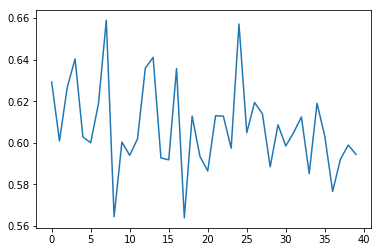

In [140]:
plt.plot(hist.history['val_loss'])

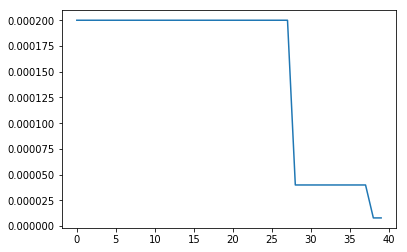

In [141]:
plt.plot(hist.history['lr'])

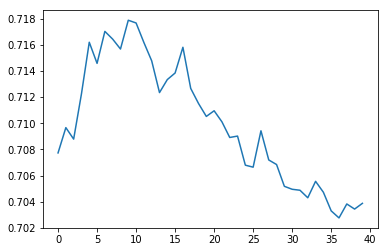

In [142]:
plt.plot(auccheckpoint.auc_history)

In [37]:
DX1_array_tst = tst_df.DX1.map(DX_dict).values

In [38]:
DX_df_tst = tst_df[DXs]
DX_df_tst = DX_df_tst.fillna('missing')
DX_df_tst[DX_df_tst.isin(['invl', 'incn'])]
#DX_df_tst[DX_df_tst.isin(rare_code)] = 'missing'
DX_df_tst[DX_df_tst.isin(unclassified)] = 'missing'

for dx in DXs:
    DX_df_tst[dx] = DX_df_tst[dx].map(DX_dict)

DX_mat_tst = DX_df_tst.values

DX_mat_tst.sort(axis=1)
#DX_mat_tst = DX_mat_tst[:, ::-1]

In [39]:
PR_df_tst = tst_df[PRs]
PR_df_tst = PR_df_tst.fillna('missing')
PR_df_tst[PR_df_tst.isin(['invl', 'incn'])] = 'missing'
#PR_df_tst[PR_df_tst.isin(pr_rare_code)] = 'missing'

for pr in PRs:
    PR_df_tst[pr] = PR_df_tst[pr].map(PR_dict)

PR_mat_tst = PR_df_tst.values
PR_mat_tst.sort(axis=1)

In [40]:
demo_mat_tst = tst_df[['AGE', 'FEMALE']].values
demo_mat_tst[:, 0] = (demo_mat_tst[:, 0]-age_mean)/age_std

hosp_array_tst = tst_df['HOSP_NRD'].map(hosp_dict).values

pay1_mat_tst = to_categorical(tst_df.PAY1.values)[:, 1:]

los_array_tst = (tst_df.LOS.values - los_mean)/los_std

ed_mat_tst = to_categorical(tst_df.HCUP_ED.values)

zipinc_mat_tst = to_categorical(tst_df.ZIPINC_QRTL.values)[:, 1:]

transfer_mat_tst = to_categorical(tst_df.SAMEDAYEVENT.values)

other_mat_tst = np.concatenate((demo_mat_tst, pay1_mat_tst, los_array_tst.reshape(los_array_tst.shape+(1,)), 
                                ed_mat_tst, zipinc_mat_tst, transfer_mat_tst), axis=1)

In [143]:
model.load_weights(model_path+'ami_glove_auc1.h5')

In [144]:
y = model.predict([DX1_array_tst, DX_mat_tst, PR_mat_tst, hosp_array_tst, other_mat_tst], verbose=1)

y_pred = y[:, 1]
y_true = tst_df.readm30.astype(int).values

18186/18186 [==============================] - 1s 36us/step


{0: 0.7136015961634182}

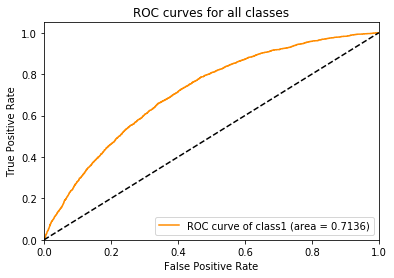

In [145]:
plot_roc(y_pred, y_true)

## Embedding Visualization

In [174]:
from sklearn import decomposition, manifold

tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)

In [175]:
DX1_embed_mat = embed_glove[1:n_DX_cat, ]

In [230]:
DX_embed_mat = embed_glove[n_DX_cat:(2*n_DX_cat-1), ]
PR_embed_mat = embed_glove[(2*n_DX_cat-1):, ]

In [231]:
embed_tsne = tsne.fit_transform(DX_embed_mat)

In [182]:
dx_multi = dx_multi.set_index(dx_multi.ICD9CM_CODE).drop(['ICD9CM_CODE'], axis=1)

In [183]:
dx_multi['finest_non_empty'] = dx_multi.CCS_LVL4
dx_multi.finest_non_empty[dx_multi.finest_non_empty==''] = dx_multi.CCS_LVL3[dx_multi.finest_non_empty == '']
dx_multi.finest_non_empty[dx_multi.finest_non_empty==''] = dx_multi.CCS_LVL2[dx_multi.finest_non_empty == '']
dx_multi.finest_non_empty[dx_multi.finest_non_empty==''] = dx_multi.CCS_LVL1[dx_multi.finest_non_empty == '']

In [184]:
ccs_lvl1 = [dx_multi.loc[c, 'CCS_LVL1']+'. '+dx_multi.loc[c, 'CCS_LVL1_LABEL'] for c in code_cat[n_DX_cat:(2*n_DX_cat-1)]]

In [185]:
fine_group = [dx_multi.loc[c, 'finest_non_empty'] for c in code_cat[n_DX_cat:(2*n_DX_cat-1)]]

In [232]:
plot_df = pd.DataFrame(dict(x=embed_tsne[:, 0], y=embed_tsne[:, 1], lvl1=ccs_lvl1, fine_group=fine_group))

In [187]:
plot_df = plot_df.assign(level=[len(g.split('.')) for g in plot_df.fine_group])

In [233]:
groups = plot_df.groupby('lvl1')

gkey = groups.size().sort_values(ascending=False).index

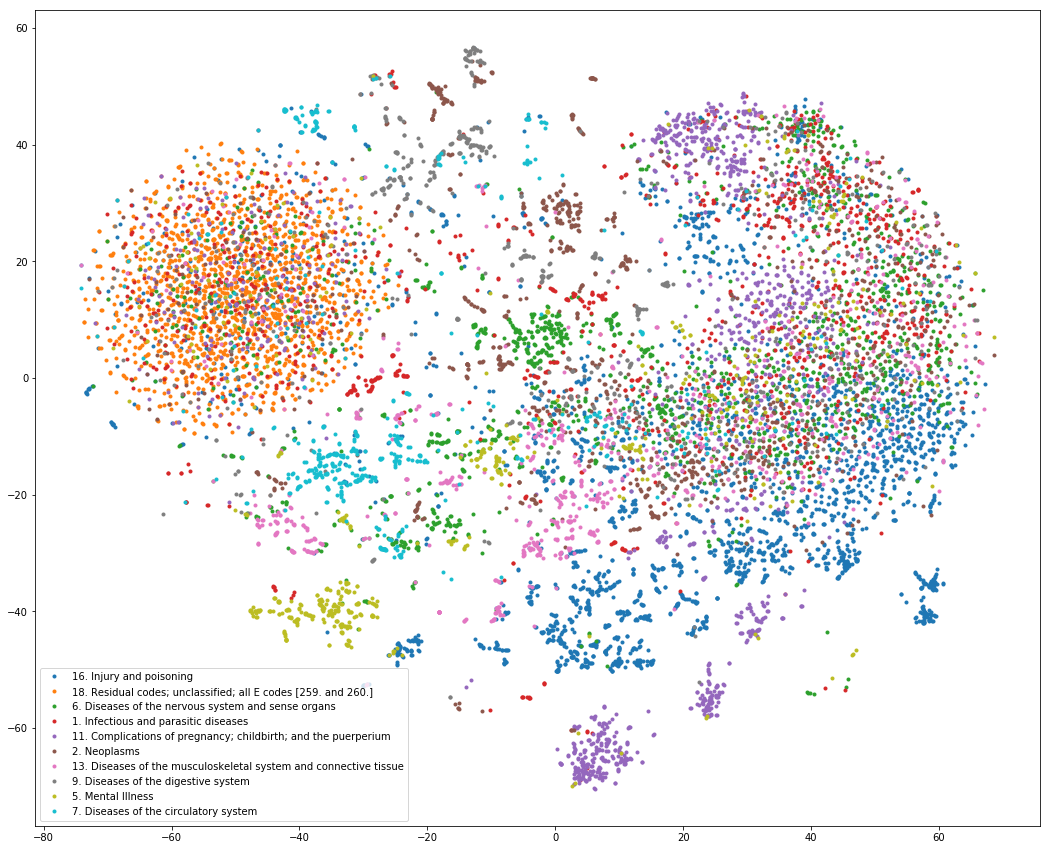

In [234]:
fig, ax = plt.subplots(figsize=(18, 15))
for name in gkey[:10]:
    group = groups.get_group(name)
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=3, label=name)
ax.legend()

In [206]:
groups = plot_df.groupby('fine_group')

gkey = groups.size().sort_values(ascending=False).index

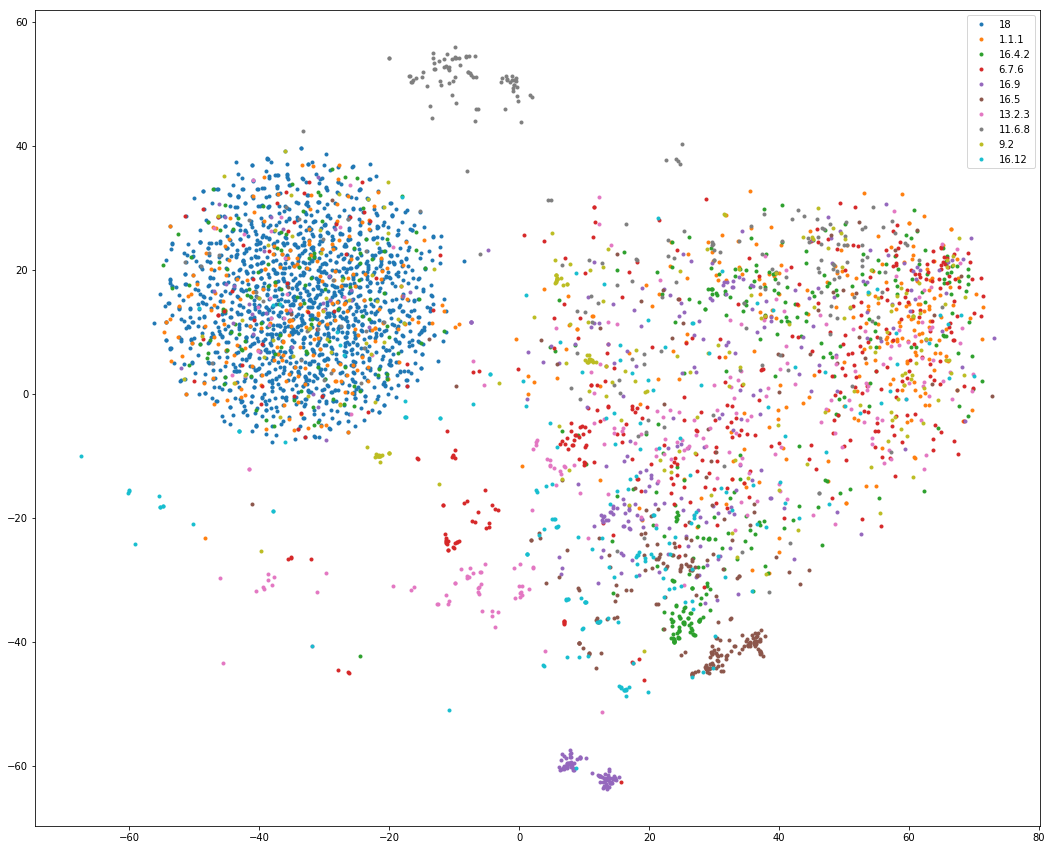

In [207]:
fig, ax = plt.subplots(figsize=(18, 15))
for name in gkey[:10]:
    group = groups.get_group(name)
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=3, label=name)
ax.legend()

In [235]:
PR_tsne = tsne.fit_transform(PR_embed_mat)

In [211]:
pr_multi = pr_multi.set_index(pr_multi.ICD9CM_CODE).drop(['ICD9CM_CODE'], axis=1)

AttributeError: 'DataFrame' object has no attribute 'ICD9CM_CODE'

In [213]:
pr_lvl1 = [pr_multi.loc[c, 'CCS_LVL1']+'. '+pr_multi.loc[c, 'CCS_LVL1_LABEL'] for c in code_cat[(2*n_DX_cat-1):]]

In [236]:
plot_df = pd.DataFrame(dict(x=PR_tsne[:, 0], y=PR_tsne[:, 1], lvl1=pr_lvl1))

In [237]:
groups = plot_df.groupby('lvl1')
gkey = groups.size().sort_values(ascending=False).index

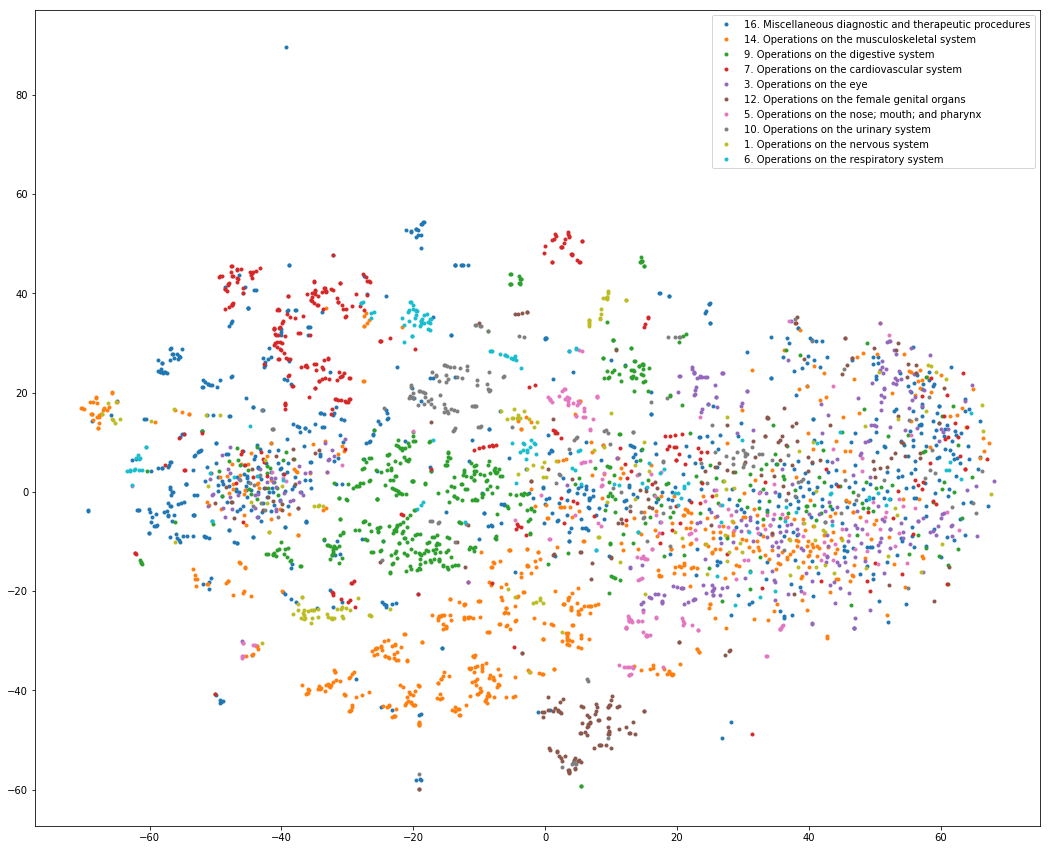

In [238]:
fig, ax = plt.subplots(figsize=(18, 15))
for name in list(gkey)[:10]:
    group = groups.get_group(name)
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=3, label=name)
ax.legend()

## Model Average

In [7]:
from sklearn.metrics import roc_curve, auc

In [14]:
y_pred_lst = []
n_fold = 50
for fold_ind in range(n_fold):
    y_pred_lst.append(np.load('output/y_pred'+str(fold_ind)+'.npy'))

In [11]:
y_true = tst_df.readm30.astype(int).values

In [15]:
auc_lst = []

for y_pred in y_pred_lst:
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    auc_lst.append(roc_auc)

In [19]:
np.mean(auc_lst), np.max(auc_lst)

(0.717115471220097, 0.7195931556050359)

In [20]:
y_pred_mat = np.column_stack(y_pred_lst)

In [21]:
y_pred_avg = y_pred_mat.mean(axis=1)

{0: 0.7201766960533637}

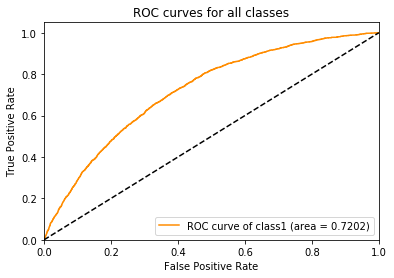

In [22]:
plot_roc(y_pred_avg, y_true)

In [172]:
np.save('output/y_pred_0816_10.npy', y_pred_mat)